In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [15]:
#unzipping

import zipfile

z= zipfile.ZipFile('/content/archive (8).zip')
z.extractall()

In [16]:
data_dir = '/content/brain_tumor_dataset'
categories = ['no', 'yes']  # no = no tumor, yes = tumor

data = []

IMG_SIZE = 150

for category in categories:
    folder = os.path.join(data_dir, category)
    label = categories.index(category)

    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append([img, label])
        except:
            pass


In [17]:
random.shuffle(data)

X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0  # Normalize
y = np.array(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# EDA, how many images available in Y, N files
yeslist= os.listdir("brain_tumor_dataset/yes/")

number_files_yes= len(yeslist)
print(number_files_yes)

nolist= os.listdir("brain_tumor_dataset/no/")
number_files_no= len(nolist)
print(number_files_no)

155
98


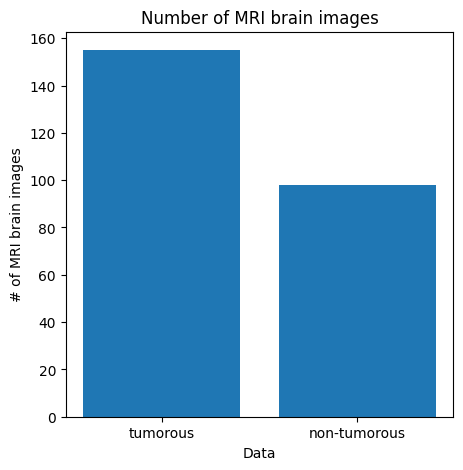

In [19]:
#plotting

data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}
typex= data.keys()
values= data.values()
fig = plt.figure(figsize = (5, 5))

plt.bar(typex, values)
plt.xlabel('Data')
plt.ylabel('# of MRI brain images')
plt.title('Number of MRI brain images')
plt.show()


#**Adding Augmented Data**




In [20]:
tumor_dir = os.path.join(data_dir, 'yes')
no_tumor_dir = os.path.join(data_dir, 'no')


In [21]:
def load_images_from_folder(folder, count):
    images = []
    for i, filename in enumerate(os.listdir(folder)):
        if i >= count:
            break
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images


In [25]:
tumor_images = load_images_from_folder(tumor_dir, 5)
no_tumor_images = load_images_from_folder(no_tumor_dir, 5)


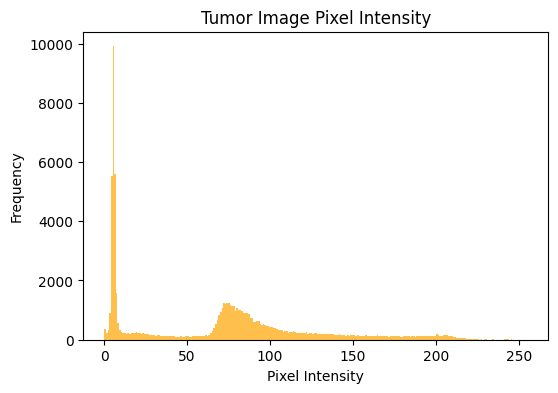

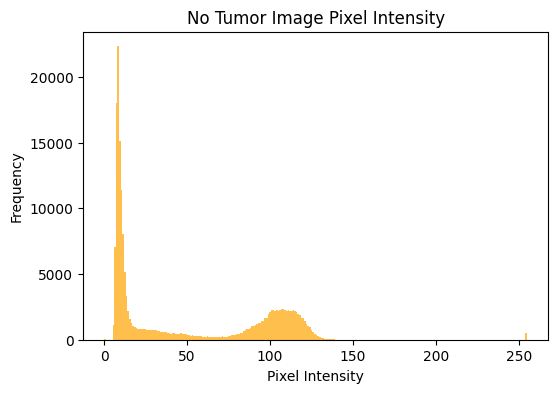

In [32]:
import matplotlib.pyplot as plt

def plot_histograms(image, title):
    """
    Plots a histogram of pixel intensity values for a given grayscale image.
    """
    plt.figure(figsize=(6, 4))
    plt.hist(image.ravel(), bins=256, color='orange', alpha=0.7)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(False)
    plt.show()

plot_histograms(tumor_images[0], "Tumor Image Pixel Intensity")
plot_histograms(no_tumor_images[0], "No Tumor Image Pixel Intensity")


In [33]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=(0.3, 1.0),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1, ) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,
                                   save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break


In [28]:
def timing(sec_elapsed):
  h= int(sec_elapsed/ (60*60))
  m= int((sec_elapsed % (60*60))/60)
  s= sec_elapsed % 60

  return f"{h}:{m}:{round(s,1)}"


In [29]:
import time
start_time=time.time()

yes_path= 'brain_tumor_dataset/yes'
no_path='brain_tumor_dataset/no'

augmented_data_path= 'augmented_data/'

import os

augmented_data_path = 'augmented_data/'

# Make sure directories exist
os.makedirs(os.path.join(augmented_data_path, 'yes'), exist_ok=True)
os.makedirs(os.path.join(augmented_data_path, 'no'), exist_ok=True)

augmented_data(file_dir= yes_path, n_generated_samples=6, save_to_dir= augmented_data_path+'yes')
augmented_data(file_dir= no_path, n_generated_samples=9, save_to_dir= augmented_data_path+'no')

end_time= time.time()
execution_time= (end_time-start_time)
print(f"Elapsed time: {timing(execution_time)}")

Elapsed time: 0:1:53.0


In [34]:
def data_summary(main_path):
    yes_path = os.path.join(main_path, 'yes')
    no_path = os.path.join(main_path, 'no')

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))
    n = n_pos + n_neg

    pos_per = (n_pos * 100) / n
    neg_per = (n_neg * 100) / n

    print(f"Total number of samples: {n}")
    print(f"Positive samples: {n_pos}, ({pos_per:.2f}%)")
    print(f"Negative samples: {n_neg}, ({neg_per:.2f}%)")


In [35]:
data_summary(augmented_data_path)

Total number of samples: 2064
Positive samples: 1085, (52.57%)
Negative samples: 979, (47.43%)


# **Data** **Augmentation**

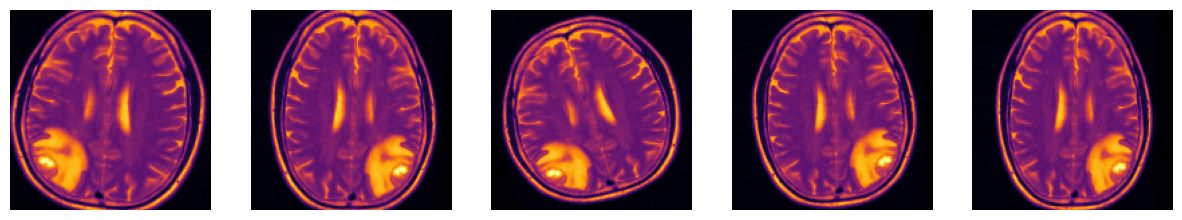

In [36]:
#augmentation data (tumor)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, horizontal_flip=True)

# Resize first
img = cv2.resize(tumor_images[0], (IMG_SIZE, IMG_SIZE))
img = img.reshape((IMG_SIZE, IMG_SIZE, 1))
img = img.astype('float32') / 255.0
img = img.reshape((1, IMG_SIZE, IMG_SIZE, 1))

aug_iter = datagen.flow(img)

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    batch = next(aug_iter)
    axs[i].imshow(batch[0].reshape(IMG_SIZE, IMG_SIZE), cmap='inferno')
    axs[i].axis('off')
plt.show()



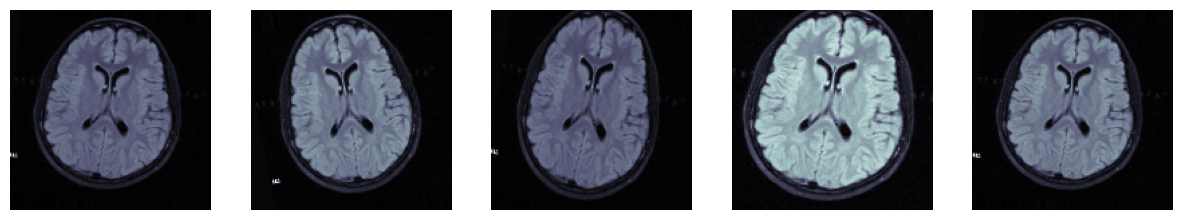

In [37]:
#augmentation data (no tumors)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, horizontal_flip=True)

# Resize before reshaping
img = cv2.resize(no_tumor_images[0], (IMG_SIZE, IMG_SIZE))
img = img.reshape((IMG_SIZE, IMG_SIZE, 1))
img = img.astype('float32') / 255.0
img = img.reshape((1, IMG_SIZE, IMG_SIZE, 1))

aug_iter = datagen.flow(img)

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    batch = next(aug_iter)
    axs[i].imshow(batch[0].reshape(IMG_SIZE, IMG_SIZE), cmap='bone')
    axs[i].axis('off')
plt.show()


# **Data Visualization**

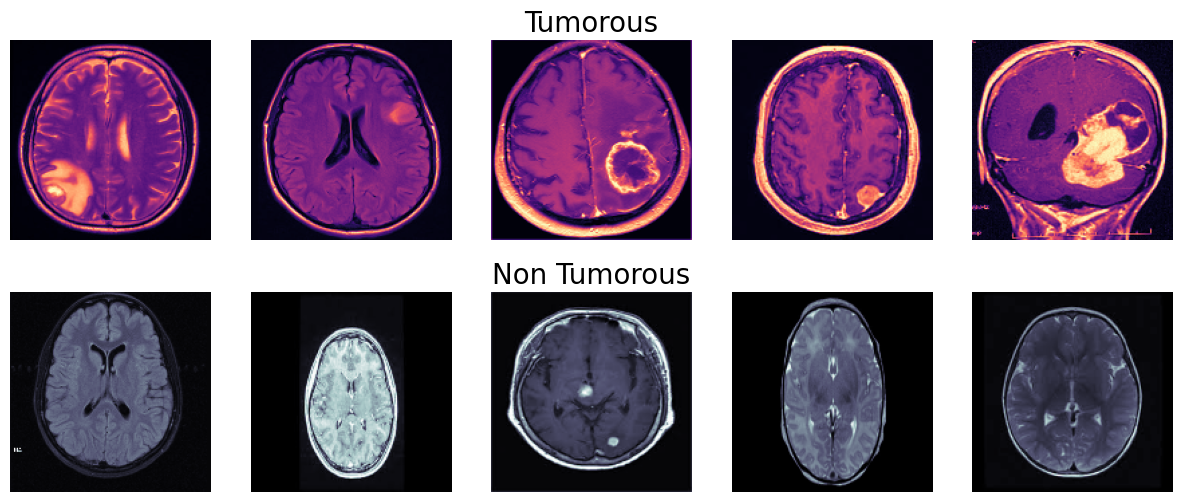

In [38]:
def load_images_from_folder(folder, num_images=5):
    images = []
    filenames = os.listdir(folder)[:num_images]
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
    return images

# Loading images
tumor_images = load_images_from_folder(tumor_dir, 5)
no_tumor_images = load_images_from_folder(no_tumor_dir, 5)

# Plotting
fig, axes = plt.subplots(2, 5, figsize=(15,6))

for i in range(5):
    axes[0, i].imshow(tumor_images[i], cmap='magma')
    axes[0, i].axis('off')
    if i == 2:
        axes[0, i].set_title('Tumorous', fontsize=20)

    axes[1, i].imshow(no_tumor_images[i], cmap='bone')
    axes[1, i].axis('off')
    if i == 2:
        axes[1, i].set_title('Non Tumorous', fontsize=20)


# **Building CNN model**

In [39]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 50

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary',
    subset='training',

)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary',
    subset='validation',

)

def preprocess_input_vgg(x):
    return tf.image.grayscale_to_rgb(x)

# Create the base model with weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze base model layers to prevent training them initially
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # binary classification

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)
    ]
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 69s 10s/step - accuracy: 0.5383 - loss: 0.7141 - val_accuracy: 0.6200 - val_loss: 0.5807 - learning_rate: 1.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 72s 11s/step - accuracy: 0.6278 - loss: 0.6797 - val_accuracy: 0.7800 - val_loss: 0.5173 - learning_rate: 1.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 9s/step - accuracy: 0.6379 - loss: 0.6067 - val_accuracy: 0.7800 - val_loss: 0.4535 - learning_rate: 1.0000e-04
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 66s 10s/step - accuracy: 0.7126 - loss: 0.5555 - val_accuracy: 0.7600 - val_loss: 0.4596 - learning_rate: 1.0000e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 9s/step - accuracy: 0.7607 - loss: 0.5150 - val_accuracy: 0.7800 - val_loss: 0.4598 - learning_rate: 1.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 10s/step - accuracy: 0.7793 - loss: 0.4733 - val_accuracy: 0.8000 - val_loss: 0.4633 - learning_rate: 1.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 74s 11s/step - accuracy: 0.7806 - loss: 0.4564 -

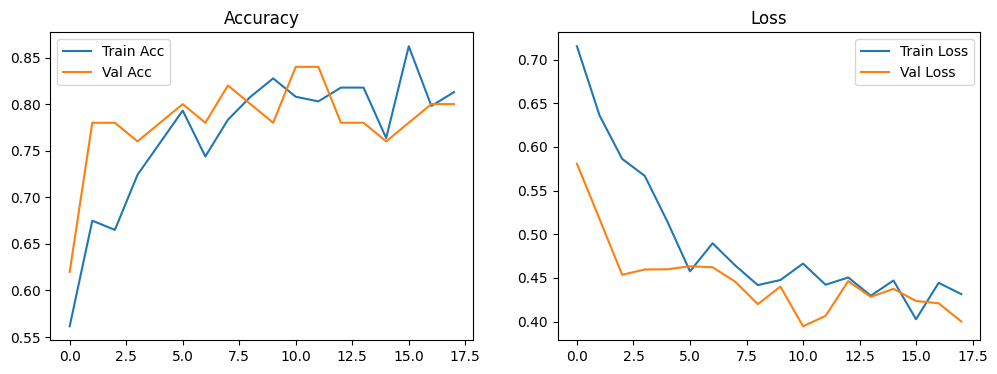

In [43]:
# Plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [44]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

Final Training Accuracy: 81.28%
Final Validation Accuracy: 80.00%
